# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.1+cpu  Device: cpu


## 3. CIFAR10 Data Normalization and Augmentation

In [3]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


문제) 학습 데이터(training data)의 색상별 평균과 표준 편차를 구하자.

In [4]:
print(train_data.data.shape)
print(train_data.data.mean(axis = (0, 1, 2))/255)
print(train_data.data.std(axis = (0, 1, 2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


문제) 위 내용을 반영하여 데이터를 Normalize 하고 랜덤하게 좌우반전 및 흑백 사진으로 바꾸자.

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.49139968, 0.48215841, 0.44653091), std = (0.24703223, 0.24348513, 0.26158784)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale()
    ])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


완성된 dataset.CIFAR10 객체를 train_loader에 넣는다.

In [6]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)    

아래의 코드를 여러번 돌려, 실제로 좌우반전 및 흑백사진으로 변하는지 확인하자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


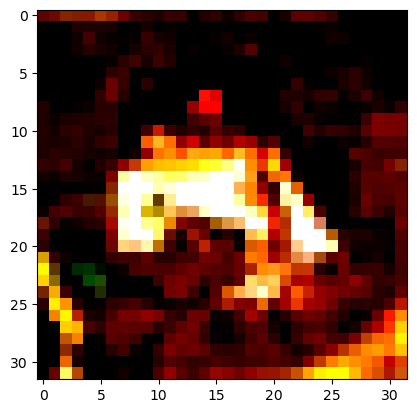

In [7]:
for (X_train, y_train) in train_loader:
    plt.imshow(X_train[0].permute(1,2,0).numpy())
    plt.show()
    break

## 4. torch.nn을 이용하여 모델-1 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Batch Normalization 을 사용할 것

In [8]:
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(100)
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 5. torch.nn을 이용하여 모델-2 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!
   
   5) Dropout을 확률을 50%로 사용할 것 - BN는 사용하지 말것!

In [9]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [10]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, -1) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(batch_size, -1)

        # Forward propagration 계산하기.
        outputs = network.forward(image)
        
        
        # loss_func 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs, dim=1)
        train_correct += pred.eq(label).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [11]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(batch_size, -1)

            # Forward propagration 계산하기.
            outputs = network.forward(image)

            # loss_func 함수를 적용하여 loss를 구하고 저장하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.argmax(outputs, dim=1)
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

1. SGD Optimizer를 사용하고

2. Regularizer 를 사용하여 (weight_decay = 0.01로 사용할 것)

학습시키기

In [12]:
def training(network, learning_rate = 0.01):
    
#     learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, weight_decay=0.01)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [13]:
network = Model_1()
rlt_const = training(network)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.423123
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.883198
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.808828
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.985192

Training set: Accuracy: 18882/50000 (38%)
Test set: Accuracy: 4276/10000 (43%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.766654
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.671951
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.853332
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.941940

Training set: Accuracy: 21361/50000 (43%)
Test set: Accuracy: 4509/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.725118
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.734365
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.785961
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.871817

Training set: Accuracy: 22153/50000 (44%)
Test set: Accuracy: 4623/10000 (46%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.759655
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.555363
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.663558
Train Epoch: 3 [48000/50000

In [14]:
network2 = Model_2()
rlt_const2 = training(network2, 0.01)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.304335
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.822345
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.771026
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.098015

Training set: Accuracy: 17009/50000 (34%)
Test set: Accuracy: 4161/10000 (42%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.808228
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.743302
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.915531
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.101361

Training set: Accuracy: 19008/50000 (38%)
Test set: Accuracy: 4326/10000 (43%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.848374
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.748214
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.711558
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.152091

Training set: Accuracy: 19485/50000 (39%)
Test set: Accuracy: 4507/10000 (45%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.819329
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.754339
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.694879
Train Epoch: 3 [48000/50000

# 8.학습 결과 보기 
## loss와 Accuracy 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

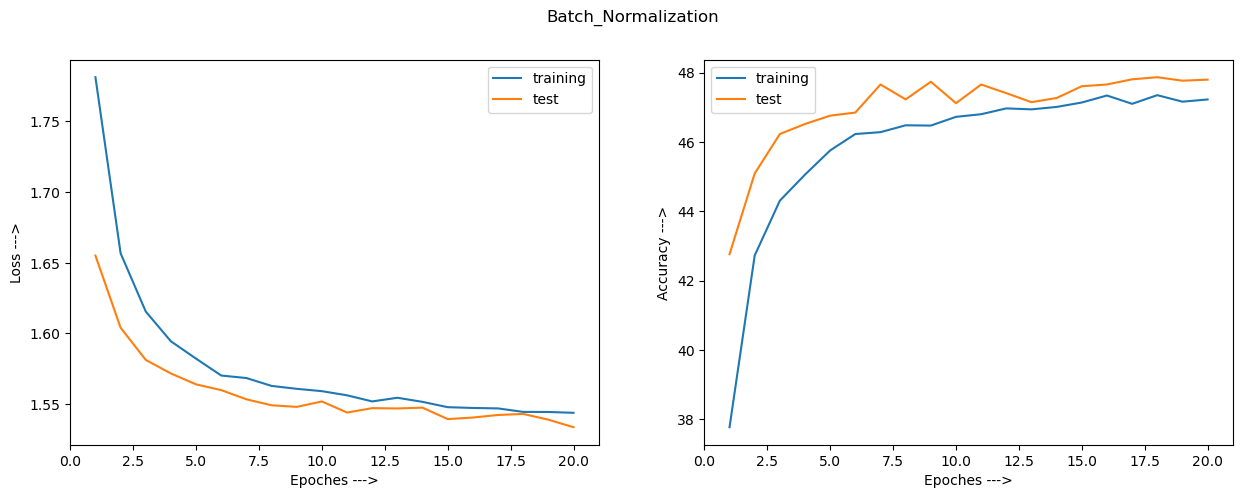

In [16]:
show_rlt(rlt_const, 'Batch_Normalization')

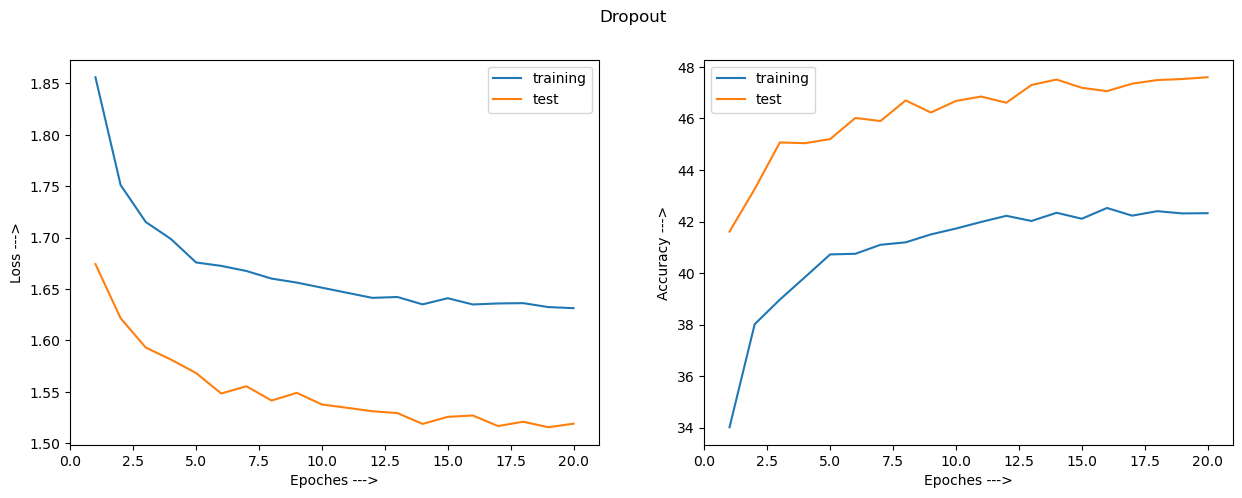

In [17]:
show_rlt(rlt_const2, 'Dropout')

# 9. Hyperparameter 찾기

위 Dropout 모델의 최적의 learning rate를 찾으세요.

스스로 계획을 짜고 어떤 lr 이 가장 나은 성능을 내었는지 분석하세요.

초기 lr값 0.05부터 0.01씩 줄여나가며 epoch 5회의 결과를 비교한다.  
0.05 : test set 정확도가 37% 정도로 좋지 않은 성능을 보임  
0.04 : test set 정확도가 37\~41% 정도로 나옴   
0.03 : test set 정확도가 43% 정도로 나옴  
0.02 : test set 정확도가 44% 정도로 나옴  
0.01 : test set 정확도가 46% 정도로 나옴  
=> lr=0.01일 때, 가장 좋은 결과를 가질 가능성이 크다는 것을 알 수 있다.